### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import optuna
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss

### Configurations

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
mode = 'local'

if mode == 'online':
    input_path = '/kaggle/input/icr-identify-age-related-conditions'
    output_path = '/kaggle/working'
elif mode == 'local':
    input_path = '../data/icr-identify-age-related-conditions'
    output_path = '../data/output'

### UDFs

In [4]:
def count_plot(x, dataframe, ax=None, **kwargs):
    if len(kwargs)==1 and kwargs['mode']=='horizontal':
        sns.countplot(y=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    else:
        sns.countplot(x=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    plt.box(False)
    return None

    
def pie_plot(df_col, fig_size, title):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(df_col.values, autopct='%1.2f%%', shadow=False, startangle=90)
    ax.axis('equal')
    plt.legend(labels=df_col.index, bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    return None


def stacked_vbar_plot(dataframe, value, index, column, xlabel, fig_size, with_percent=True):
    
    df_1 = dataframe.pivot_table(values=[value], index=[index], columns=[column], aggfunc=len, margins=True)
    df_1_percent = df_1.div(df_1.iloc[:,-1], axis=0).mul(100, axis=0).round(2)
    df_2_percent = df_1_percent.iloc[:, :-1].drop('All')
    
    columns = df_2_percent.columns.levels[1].tolist()
    columns.remove('All')
    
    ax = df_2_percent.plot.bar(stacked=True)
    ax.figure.set_size_inches(fig_size)
    ax.grid(False)
    plt.legend(labels=columns, bbox_to_anchor=(1.05, 1), title='NPS Type')
    plt.xlabel(xlabel)
    plt.ylabel('%GT Count of NPS_Type')
    
    if with_percent:
        # Add this loop to add the annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.2f}%'.format(height), (x + width/8, y + height/2))
    plt.box(False)
    plt.show()
    return None


def pdf_distribution_plots(df, features, target):
    nrow = int((len(features)/3) + len(features)%3)
    
    t0 = df.loc[df[target] == 0]
    t1 = df.loc[df[target] == 1]

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,10))

    for indx, feature in enumerate(features):
        ax = fig.add_subplot(nrow, 3, indx+1)
        sns.kdeplot(t0[feature], label="0", legend=True)
        sns.kdeplot(t1[feature], label="1", legend=True)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='best')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace= 0.3, hspace=0.5)
    plt.show()
    return None


def clipping(dataframe, num_cols):
    df_copy = dataframe.copy()
    for col in num_cols:
        p25 = np.percentile(df_copy[col], 25)
        p75 = np.percentile(df_copy[col], 75)
        iqr = p75 - p25
        df_copy[col] = np.clip(df_copy[col], a_min=np.floor((p25 - 1.5*iqr)), a_max=np.ceil((p75 + 1.5*iqr)))
    return df_copy


def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = col + '_CAT'
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df


def feat_import(model, x_train):
    importance = model.feature_importances_
    imp=list(importance)
    feature_set=x_train.columns
    
    imp_df=pd.DataFrame({'Feature':feature_set,'Importance':imp})
    imp_df=imp_df.sort_values(by='Importance',ascending=False)
    
    return imp_df

### Load Data

In [5]:
train_df = pd.read_csv(f'{input_path}/train.csv')
inf_df = pd.read_csv(f'{input_path}/test.csv')

print(f'Training dataset shape: {train_df.shape}')
print(f'Inference dataset shape: {inf_df.shape}')

train_df.head()

Training dataset shape: (617, 58)
Inference dataset shape: (5, 57)


Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC         BD        BN          BP  \
0  0.699861  0.025578   9.812214    5.555634  4126.58731  22.5984  175.638726   
1  3.632190  0.025578  13.517790    1.229900  5496.92824  19.4205  155.868030   
2  6.732840  0.025578  12.824570    1.229900  5135.78024  26.4825  128.988531   
3  3.685344  0.025578  11.053708    1.229900  4169.67738  23.6577  237.282264   
4  3.942255  0.054810   3.396778  102.151980  5728.73412  24.0108  324.546318   

           BQ           BR          BZ         CB        CC        CD   \
0  152.707705   823.928241  257.432377  47.223358  0.563481  23.387600   
1   14.754720    51.216883  257.432377  30.284345  0.484710  50.628208   
2  219.320160   482.141594  257.432377  32.563713  0.495852  85.955376   
3   11.050410   661.518640  257.432377  15.201914  0.717882  88.159360   
4  149.717165  6074.859475  257.432377  82.213495  0.536467  72.644264   

          CF        CH        CL        CR         CS        CU        CW   \
0   4.851915  0.023482  1.050225  0.069225  13.784111  1.302012  36.205956   
1   6.085041  0.031442  1.113875  1.117800  28.310953  1.357182  37.476568   
2   5.376488  0.036218  1.050225  0.700350  39.364743  1.009611  21.459644   
3   2.347652  0.029054  1.400300  0.636075  41.116960  0.722727  21.530392   
4  30.537722  0.025472  1.050225  0.693150  31.724726  0.827550  34.415360   

         DA          DE       DF        DH          DI        DL         DN  \
0  69.08340  295.570575  0.23868  0.284232   89.245560  84.31664  29.657104   
1  70.79836  178.553100  0.23868  0.363489  110.581815  75.74548  37.532000   
2  70.81970  321.426625  0.23868  0.210441  120.056438  65.46984  28.053464   
3  47.27586  196.607985  0.23868  0.292431  139.824570  71.57120  24.354856   
4  74.06532  200.178160  0.23868  0.207708   97.920120  52.83888  26.019912   

         DU       DV         DY        EB        EE            EG        EH  \
0  5.310690  1.74307  23.187704  7.294176  1.987283   1433.166750  0.949104   
1  0.005518  1.74307  17.222328  4.926396  0.858603   1111.287150  0.003042   
2  1.289739  1.74307  36.861352  7.813674  8.146651   1494.076488  0.377208   
3  2.655345  1.74307  52.003884  7.386060  3.813326  15691.552180  0.614484   
4  1.144902  1.74307   9.064856  7.350720  3.490846   1403.656300  0.164268   

  EJ          EL         EP         EU          FC        FD             FE  \
0  B   30.879420  78.526968   3.828384   13.394640  10.265073   9028.291921   
1  A  109.125159  95.415086  52.260480   17.175984   0.296850   6785.003474   
2  B  109.125159  78.526968   5.390628  224.207424   8.745201   8338.906181   
3  B   31.674357  78.526968  31.323372   59.301984   7.884336  10965.766040   
4  B  109.125159  91.994825  51.141336   29.102640   4.274640  16198.049590   

          FI        FL        FR        FS         GB          GE  \
0   3.583450  7.298162   1.73855  0.094822  11.339138   72.611063   
1  10.358927  0.173229   0.49706  0.568932   9.292698   72.611063   
2  11.626917  7.709560   0.97556  1.198821  37.077772   88.609437   
3  14.852022  6.122162   0.49706  0.284466  18.529584   82.416803   
4  13.666727  8.153058  48.50134  0.121914  16.408728  146.109943   

             GF         GH         GI         GL  Class  
0   2003.810319  22.136229  69.834944   0.120343      1  
1  27981.562750  29.135430  32.131996  21.978000      0  
2  13676.957810  28.022851  35.192676   0.196941      0  
3   2094.262452  39.948656  90.493248   0.155829      0  
4   8524.370502  45.381316  36.262628

### Data Pre-processing

In [6]:
# Remove whitespaces from column names
train_df.columns = train_df.columns.str.replace(' ', '')
inf_df.columns = inf_df.columns.str.replace(' ', '')

In [7]:
# Define attributes
id = ['Id']
target = ['Class']

num_feat = train_df.drop(columns=['Id', 'Class']).select_dtypes(exclude=['object']).columns.tolist()
print(f'Numerical Features: {num_feat}')

cat_feat = train_df.drop(columns=['Id', 'Class']).select_dtypes(include=['object']).columns.tolist()
print(f'Categorical Features: {cat_feat}')

Numerical Features: ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
Categorical Features: ['EJ']


#### Check for Duplicates

In [8]:
duplicates_present = train_df.duplicated()
duplicate_rows = train_df[train_df.duplicated()]

print(f"Duplicate rows present:\n{duplicate_rows}")

Duplicate rows present:
Empty DataFrame
Columns: [Id, AB, AF, AH, AM, AR, AX, AY, AZ, BC, BD, BN, BP, BQ, BR, BZ, CB, CC, CD, CF, CH, CL, CR, CS, CU, CW, DA, DE, DF, DH, DI, DL, DN, DU, DV, DY, EB, EE, EG, EH, EJ, EL, EP, EU, FC, FD, FE, FI, FL, FR, FS, GB, GE, GF, GH, GI, GL, Class]
Index: []


#### Handle Missing Values

In [9]:
# Missing data - training set
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

Total   Percent
EL     60  0.097245
BQ     60  0.097245
CC      3  0.004862
FS      2  0.003241
CB      2  0.003241
FL      1  0.001621
FC      1  0.001621
DU      1  0.001621
GL      1  0.001621
EE      0  0.000000

In [10]:
# Missing data - inference set
total = inf_df.isnull().sum().sort_values(ascending=False)
percent = (inf_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total  Percent
Id    0.0      0.0
DH    0.0      0.0
DL    0.0      0.0
DN    0.0      0.0
DU    0.0      0.0

In [11]:
# Initialize the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
train_imputed_df = pd.DataFrame(knn_imputer.fit_transform(train_df[num_feat]), columns=num_feat)
inf_imputed_df =pd.DataFrame(knn_imputer.transform(inf_df[num_feat]), columns=num_feat)

# Check if there are still missing values in the train and test data sets
df_train_null = train_imputed_df[train_imputed_df.isnull().any(axis=1)]
df_inf_null = inf_imputed_df[inf_imputed_df.isnull().any(axis=1)]

# Display the rows with null values
print('No. of records with missing value in Train data set after Imputation : {}'.format(df_train_null.shape[0]))
print('No. of records with missing value in Test data set after Imputation : {}'.format(df_inf_null.shape[0]))

# Replace the imputed columns in the train data sets
train_df = train_df.drop(columns=num_feat, axis=1)
train_df = pd.concat([train_df, train_imputed_df], axis=1)

# Replace the imputed columns in the test data sets
inf_df = inf_df.drop(columns=num_feat, axis=1)
inf_df = pd.concat([inf_df, inf_imputed_df], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(train_df.shape))
print('Shape of the Test data set : {}'.format(inf_df.shape))

No. of records with missing value in Train data set after Imputation : 0
No. of records with missing value in Test data set after Imputation : 0
Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


In [12]:
'''
# Replacing missing data based on "EJ"

missing_num_cols = train_df.drop(columns=['Id', 'Class']).columns[train_df.drop(columns=['Id', 'Class']).isnull().any()].tolist()
print(f'Missing values found in: {missing_num_cols}')

for missing_num_col in missing_num_cols:
    feat_by_ej = train_df.groupby('EJ')[missing_num_col].median()
    train_df[missing_num_col] = train_df.apply(lambda row: feat_by_ej[row['EJ']] if pd.isnull(row[missing_num_col]) else row[missing_num_col], axis=1)
    inf_df[missing_num_col] = inf_df.apply(lambda row: feat_by_ej[row['EJ']] if pd.isnull(row[missing_num_col]) else row[missing_num_col], axis=1)
'''

'\n# Replacing missing data based on "EJ"\n\nmissing_num_cols = train_df.drop(columns=[\'Id\', \'Class\']).columns[train_df.drop(columns=[\'Id\', \'Class\']).isnull().any()].tolist()\nprint(f\'Missing values found in: {missing_num_cols}\')\n\nfor missing_num_col in missing_num_cols:\n    feat_by_ej = train_df.groupby(\'EJ\')[missing_num_col].median()\n    train_df[missing_num_col] = train_df.apply(lambda row: feat_by_ej[row[\'EJ\']] if pd.isnull(row[missing_num_col]) else row[missing_num_col], axis=1)\n    inf_df[missing_num_col] = inf_df.apply(lambda row: feat_by_ej[row[\'EJ\']] if pd.isnull(row[missing_num_col]) else row[missing_num_col], axis=1)\n'

### Feature Selection

In [13]:
# Drop following features
drop_num_feat = ['CL', 'FD']

train_df = train_df.drop(columns=drop_num_feat)
inf_df = inf_df.drop(columns=drop_num_feat)

#### Encode Categorical Features

In [14]:
train_df[cat_feat] = np.where(train_df[cat_feat]=='A', 0, 1)
inf_df[cat_feat] = np.where(inf_df[cat_feat]=='A', 0, 1)

print("Train dataset shape: {}".format(train_df.shape))
print("Inference dataset shape: {}".format(inf_df.shape))

train_df.head(3)

Train dataset shape: (617, 56)
Inference dataset shape: (5, 55)


Id  EJ  Class        AB          AF         AH         AM  \
0  000ff2bfdfe9   1      1  0.209377  3109.03329  85.200147  22.394407   
1  007255e47698   0      0  0.145282   978.76416  85.200147  36.968889   
2  013f2bd269f5   1      0  0.470030  2635.10654  85.200147  32.360553   

         AR        AX        AY         AZ        BC          BD       BN  \
0  8.138688  0.699861  0.025578   9.812214  5.555634  4126.58731  22.5984   
1  8.138688  3.632190  0.025578  13.517790  1.229900  5496.92824  19.4205   
2  8.138688  6.732840  0.025578  12.824570  1.229900  5135.78024  26.4825   

           BP          BQ          BR          BZ         CB        CC  \
0  175.638726  152.707705  823.928241  257.432377  47.223358  0.563481   
1  155.868030   14.754720   51.216883  257.432377  30.284345  0.484710   
2  128.988531  219.320160  482.141594  257.432377  32.563713  0.495852   

          CD        CF        CH        CR         CS        CU         CW  \
0  23.387600  4.851915  0.023482  0.069225  13.784111  1.302012  36.205956   
1  50.628208  6.085041  0.031442  1.117800  28.310953  1.357182  37.476568   
2  85.955376  5.376488  0.036218  0.700350  39.364743  1.009611  21.459644   

         DA          DE       DF        DH          DI        DL         DN  \
0  69.08340  295.570575  0.23868  0.284232   89.245560  84.31664  29.657104   
1  70.79836  178.553100  0.23868  0.363489  110.581815  75.74548  37.532000   
2  70.81970  321.426625  0.23868  0.210441  120.056438  65.46984  28.053464   

         DU       DV         DY        EB        EE           EG        EH  \
0  5.310690  1.74307  23.187704  7.294176  1.987283  1433.166750  0.949104   
1  0.005518  1.74307  17.222328  4.926396  0.858603  1111.287150  0.003042   
2  1.289739  1.74307  36.861352  7.813674  8.146651  1494.076488  0.377208   

           EL         EP         EU          FC           FE         FI  \
0   30.879420  78.526968   3.828384   13.394640  9028.291921   3.583450   
1  109.125159  95.415086  52.260480   17.175984  6785.003474  10.358927   
2  109.125159  78.526968   5.390628  224.207424  8338.906181  11.626917   

         FL       FR        FS         GB         GE            GF         GH  \
0  7.298162  1.73855  0.094822  11.339138  72.611063   2003.810319  22.136229   
1  0.173229  0.49706  0.568932   9.292698  72.611063  27981.562750  29.135430   
2  7.709560  0.97556  1.198821  37.077772  88.609437  13676.957810  28.022851   

          GI         GL  
0  69.834944   0.120343  
1  32.131996  21.978000  
2  35.192676   0.196941

#### Feature Scaling

In [15]:
# Scale numerical features
scale_cols = [col for col in num_feat if col not in drop_num_feat]

scaler = RobustScaler().fit(train_df[scale_cols]) # StandardScaler(), MinMaxScaler()

train_df[scale_cols] = scaler.transform(train_df[scale_cols])
inf_df[scale_cols] = scaler.transform(inf_df[scale_cols])

### Model Development

In [16]:
# Final features
final_feat_cols = train_df.drop(columns=id+target).columns.to_list()
print(f'Final features: {final_feat_cols}')

Final features: ['EJ', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


In [17]:
# Create independent and dependent variables
X = train_df[final_feat_cols]
y = train_df[target]

inf_x = inf_df[final_feat_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1295, shuffle=True, stratify=y)

y_test.value_counts()

Class
0        102
1         22
dtype: int64

In [18]:
# SMOTE oversampling
smote_ovr_sampling = SMOTE(sampling_strategy='minority', random_state=1295)

X_train_smote, y_train_smote = smote_ovr_sampling.fit_resample(X_train, y_train)

print("Dataset size after oversampling: \nX_train_smote = {}\ny_train_smote = {}".format(X_train_smote.shape, y_train_smote.shape))

y_train_smote.value_counts()

Dataset size after oversampling: 
X_train_smote = (814, 54)
y_train_smote = (814, 1)


Class
0        407
1        407
dtype: int64

#### Logistic Regression

In [19]:
lr_clf = LogisticRegression(solver='liblinear')

grid_values = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_lr_clf = GridSearchCV(lr_clf, param_grid=grid_values, scoring=['f1', 'neg_log_loss'], refit='f1', cv=5, n_jobs=1, verbose=10)

grid_lr_clf.fit(X_train_smote, y_train_smote)

print('\n\nGrid best parameter: {}'.format(grid_lr_clf.best_params_))
print('Grid best score: {:.4f}'.format(grid_lr_clf.best_score_))
print('\nBest Estimator: {}'.format(grid_lr_clf.best_estimator_))

lr_best_est = grid_lr_clf.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START C=0.001, penalty=l1........................................
[CV 1/5; 1/12] END C=0.001, penalty=l1; f1: (test=0.540) neg_log_loss: (test=-0.681) total time=   0.0s
[CV 2/5; 1/12] START C=0.001, penalty=l1........................................
[CV 2/5; 1/12] END C=0.001, penalty=l1; f1: (test=0.545) neg_log_loss: (test=-0.709) total time=   0.0s
[CV 3/5; 1/12] START C=0.001, penalty=l1........................................
[CV 3/5; 1/12] END C=0.001, penalty=l1; f1: (test=0.598) neg_log_loss: (test=-0.679) total time=   0.0s
[CV 4/5; 1/12] START C=0.001, penalty=l1........................................
[CV 4/5; 1/12] END C=0.001, penalty=l1; f1: (test=0.571) neg_log_loss: (test=-0.691) total time=   0.0s
[CV 5/5; 1/12] START C=0.001, penalty=l1........................................
[CV 5/5; 1/12] END C=0.001, penalty=l1; f1: (test=0.524) neg_log_loss: (test=-0.686) total time=   0.0s
[CV 1/5; 2/12]

In [20]:
y_train_pred_proba = lr_best_est.predict_proba(X_train_smote)
y_test_pred_proba = lr_best_est.predict_proba(X_test)
inf_x_pred_proba_lr = lr_best_est.predict_proba(inf_x)

y_train_pred = lr_best_est.predict(X_train_smote)
y_test_pred = lr_best_est.predict(X_test)

# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train_smote, y_train_pred))
print(classification_report(y_train_smote, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train_smote, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train_smote, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train_smote, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train_smote, y_train_pred)))
print("Training Set Log Loss: {:.4f}".format(log_loss(y_train_smote, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("Test Set Log Loss: {:.4f}".format(log_loss(y_test, y_test_pred)))


sub_df = pd.DataFrame({'Id': inf_df['Id'],
                    'class_0': np.round(inf_x_pred_proba_lr[:, 0], decimals=4).squeeze(),
                    'class_1': np.round(inf_x_pred_proba_lr[:, 1], decimals=4).squeeze()})

if mode == 'online':
    sub_df.to_csv(f'{output_path}/submission.csv', index=False)
elif mode == 'local':
    sub_df.to_csv(f'{output_path}/Logistic-Regression/submission.csv', index=False)

------------------------Training Set------------------------
[[388  19]
 [ 14 393]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       407
           1       0.95      0.97      0.96       407

    accuracy                           0.96       814
   macro avg       0.96      0.96      0.96       814
weighted avg       0.96      0.96      0.96       814

Training Set Accuracy: 0.9595
Training Set Precision: 0.9539
Training Set Recall: 0.9656
Training Set f1: 0.9597
Training Set Log Loss: 1.4002

--------------------------Test Set--------------------------
[[92 10]
 [ 7 15]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       102
           1       0.60      0.68      0.64        22

    accuracy                           0.86       124
   macro avg       0.76      0.79      0.78       124
weighted avg       0.87      0.86      0.87       124

Test Set Accuracy: 0.8629
Test Set Pre

#### XGBoost

In [21]:
# A parameter grid for XGBoost
params = {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
        'max_depth': randint(5, 10),
        #'gamma': uniform(0.0, 0.5),
        #'subsample': uniform(0.6, 1.0),
        #'colsample_bytree': uniform(0.6, 1.0),
        #'reg_alpha': uniform(0.0, 1.0),
        #'reg_lambda': uniform(0.0, 1.0),
        'min_child_weight': randint(3, 7)
        }

xgb_clf = XGBClassifier(learning_rate=0.005, objective='binary:logistic',
                        subsample=0.5213, colsample_bytree=0.4603, gamma=0.0468,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        random_state=1295, nthread=-1, verbosity=0)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1295)

xgb_rndm_srch = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=500,
                                   scoring='roc_auc',
                                   cv=skf.split(X_train_smote, y_train_smote),
                                   n_jobs=1, verbose=10, random_state=1295)

xgb_rndm_srch.fit(X_train_smote, y_train_smote)

xgb_best_est = xgb_rndm_srch.best_estimator_

print(f"Best parameters:\n{xgb_rndm_srch.best_params_}")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV 1/3; 1/500] START max_depth=7, min_child_weight=3, n_estimators=400.........
[CV 1/3; 1/500] END max_depth=7, min_child_weight=3, n_estimators=400;, score=0.982 total time=   0.2s
[CV 2/3; 1/500] START max_depth=7, min_child_weight=3, n_estimators=400.........
[CV 2/3; 1/500] END max_depth=7, min_child_weight=3, n_estimators=400;, score=0.983 total time=   0.1s
[CV 3/3; 1/500] START max_depth=7, min_child_weight=3, n_estimators=400.........
[CV 3/3; 1/500] END max_depth=7, min_child_weight=3, n_estimators=400;, score=0.983 total time=   0.1s
[CV 1/3; 2/500] START max_depth=7, min_child_weight=6, n_estimators=300.........
[CV 1/3; 2/500] END max_depth=7, min_child_weight=6, n_estimators=300;, score=0.972 total time=   0.1s
[CV 2/3; 2/500] START max_depth=7, min_child_weight=6, n_estimators=300.........
[CV 2/3; 2/500] END max_depth=7, min_child_weight=6, n_estimators=300;, score=0.973 total time=   0.1s
[CV 3/3; 2/500] 

In [22]:
y_train_pred_proba = xgb_best_est.predict_proba(X_train_smote)
y_test_pred_proba = xgb_best_est.predict_proba(X_test)
inf_x_pred_proba_lr = xgb_best_est.predict_proba(inf_x)

y_train_pred = xgb_best_est.predict(X_train_smote)
y_test_pred = xgb_best_est.predict(X_test)

# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train_smote, y_train_pred))
print(classification_report(y_train_smote, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train_smote, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train_smote, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train_smote, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train_smote, y_train_pred)))
print("Training Set Log Loss: {:.4f}".format(log_loss(y_train_smote, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("Test Set Log Loss: {:.4f}".format(log_loss(y_test, y_test_pred)))


sub_df = pd.DataFrame({'Id': inf_df['Id'],
                    'class_0': np.round(inf_x_pred_proba_lr[:, 0], decimals=4).squeeze(),
                    'class_1': np.round(inf_x_pred_proba_lr[:, 1], decimals=4).squeeze()})

if mode == 'online':
    sub_df.to_csv(f'{output_path}/submission.csv', index=False)
elif mode == 'local':
    sub_df.to_csv(f'{output_path}/XGBoost/submission.csv', index=False)

------------------------Training Set------------------------
[[403   4]
 [  1 406]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       407
           1       0.99      1.00      0.99       407

    accuracy                           0.99       814
   macro avg       0.99      0.99      0.99       814
weighted avg       0.99      0.99      0.99       814

Training Set Accuracy: 0.9939
Training Set Precision: 0.9902
Training Set Recall: 0.9975
Training Set f1: 0.9939
Training Set Log Loss: 0.2122

--------------------------Test Set--------------------------
[[95  7]
 [ 5 17]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       102
           1       0.71      0.77      0.74        22

    accuracy                           0.90       124
   macro avg       0.83      0.85      0.84       124
weighted avg       0.91      0.90      0.90       124

Test Set Accuracy: 0.9032
Test Set Pre

#### LightGBM

In [21]:
# A parameter grid for LightGBM
params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10],
        'min_data_in_leaf': [5, 10, 15, 20],
        'max_bin': [55, 100, 150, 255],
        'bagging_fraction': [0.8, 0.9, 1.0],
        'feature_fraction': [0.8, 0.9, 1.0]
        }

lgbm_clf = LGBMClassifier(learning_rate=0.01, objective='binary',
                          reg_alpha=0.01, reg_lambda=0.5,
                          random_state=1295, nthread=-1, verbosity=0)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1295)

lgbm_rndm_srch = RandomizedSearchCV(lgbm_clf, param_distributions=params, n_iter=200,
                                   scoring='roc_auc',
                                   cv=skf.split(X_train_smote, y_train_smote),
                                   n_jobs=1, verbose=2, random_state=1295)

lgbm_rndm_srch.fit(X_train_smote, y_train_smote)

lgbm_best_est = lgbm_rndm_srch.best_estimator_

print(f"Best parameters:\n{lgbm_rndm_srch.best_params_}")

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Curre

In [22]:
y_train_pred_proba = lgbm_best_est.predict_proba(X_train_smote)
y_test_pred_proba = lgbm_best_est.predict_proba(X_test)
inf_x_pred_proba_lgbm = lgbm_best_est.predict_proba(inf_x)

y_train_pred = lgbm_best_est.predict(X_train_smote)
y_test_pred = lgbm_best_est.predict(X_test)

# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train_smote, y_train_pred))
print(classification_report(y_train_smote, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train_smote, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train_smote, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train_smote, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train_smote, y_train_pred)))
print("Training Set Log Loss: {:.4f}".format(log_loss(y_train_smote, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("Test Set Log Loss: {:.4f}".format(log_loss(y_test, y_test_pred)))


sub_df = pd.DataFrame({'Id': inf_df['Id'],
                    'class_0': np.round(inf_x_pred_proba_lgbm[:, 0], decimals=4).squeeze(),
                    'class_1': np.round(inf_x_pred_proba_lgbm[:, 1], decimals=4).squeeze()})

if mode == 'online':
    sub_df.to_csv(f'{output_path}/submission.csv', index=False)
elif mode == 'local':
    sub_df.to_csv(f'{output_path}/LightGBM/submission.csv', index=False)

------------------------Training Set------------------------
[[407   0]
 [  0 407]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       1.00      1.00      1.00       407

    accuracy                           1.00       814
   macro avg       1.00      1.00      1.00       814
weighted avg       1.00      1.00      1.00       814

Training Set Accuracy: 1.0000
Training Set Precision: 1.0000
Training Set Recall: 1.0000
Training Set f1: 1.0000
Training Set Log Loss: 0.0000

--------------------------Test Set--------------------------
[[95  7]
 [ 6 16]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       102
           1       0.70      0.73      0.71        22

    accuracy                           0.90       124
   macro avg       0.82      0.83      0.82       124
weighted avg       0.90      0.90      0.90       124

Test Set Accuracy: 0.8952
Test Set Pre

#### CatBoost

In [20]:
def catboost_objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    catb_clf = CatBoostClassifier(objective='Logloss', **params, silent=True)
    catb_clf.fit(X_train_smote, y_train_smote)
    y_test_pred = catb_clf.predict(X_test)
    lg_loss = log_loss(y_test, y_test_pred)
    return lg_loss

study = optuna.create_study(direction='minimize')
study.optimize(catboost_objective, n_trials=30)

print(study.best_trial)
print(f"Best parameters:\n{study.best_params}")
print('Best Log Loss: {:.4f}'.format(study.best_value))

[I 2023-08-30 00:08:51,493] A new study created in memory with name: no-name-41d5c582-8c42-4817-b912-57fadafdb1ab
[I 2023-08-30 00:08:53,799] Trial 0 finished with value: 3.621032992911209 and parameters: {'learning_rate': 0.041223391096114295, 'depth': 3, 'subsample': 0.13482091131099522, 'colsample_bylevel': 0.5659290514842739, 'min_data_in_leaf': 13}. Best is trial 0 with value: 3.621032992911209.
[I 2023-08-30 00:09:00,820] Trial 1 finished with value: 2.506872467289653 and parameters: {'learning_rate': 0.04281729942535169, 'depth': 6, 'subsample': 0.11747854204193067, 'colsample_bylevel': 0.964401547473688, 'min_data_in_leaf': 92}. Best is trial 1 with value: 2.506872467289653.
[I 2023-08-30 00:09:05,467] Trial 2 finished with value: 3.899603754056868 and parameters: {'learning_rate': 0.001372153638928029, 'depth': 6, 'subsample': 0.10224829637698837, 'colsample_bylevel': 0.41697558339530505, 'min_data_in_leaf': 28}. Best is trial 1 with value: 2.506872467289653.
[I 2023-08-30 00:

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[2.506872467289653], datetime_start=datetime.datetime(2023, 8, 30, 0, 8, 53, 800262), datetime_complete=datetime.datetime(2023, 8, 30, 0, 9, 0, 820848), params={'learning_rate': 0.04281729942535169, 'depth': 6, 'subsample': 0.11747854204193067, 'colsample_bylevel': 0.964401547473688, 'min_data_in_leaf': 92}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'depth': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=1, step=1)}, trial_id=1, value=None)
Best parameters:
{'learning_rate': 0.04281729942535169, 'depth': 6, 'subsample': 0.11747854204193067, 'colsample_bylevel': 0.964401547473688, 'min_data_in_leaf': 92}
Best

In [23]:
catboost_best_est = CatBoostClassifier(objective='Logloss', **study.best_params)
catboost_best_est.fit(X_train_smote, y_train_smote, verbose=0)
y_test_pred = catboost_best_est.predict(X_test)

y_train_pred_proba = catboost_best_est.predict_proba(X_train_smote)
y_test_pred_proba = catboost_best_est.predict_proba(X_test)
inf_x_pred_proba_catb = catboost_best_est.predict_proba(inf_x)

y_train_pred = catboost_best_est.predict(X_train_smote)
y_test_pred = catboost_best_est.predict(X_test)

# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train_smote, y_train_pred))
print(classification_report(y_train_smote, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train_smote, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train_smote, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train_smote, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train_smote, y_train_pred)))
print("Training Set Log Loss: {:.4f}".format(log_loss(y_train_smote, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("Test Set Log Loss: {:.4f}".format(log_loss(y_test, y_test_pred)))


sub_df = pd.DataFrame({'Id': inf_df['Id'],
                    'class_0': np.round(inf_x_pred_proba_catb[:, 0], decimals=4).squeeze(),
                    'class_1': np.round(inf_x_pred_proba_catb[:, 1], decimals=4).squeeze()})

if mode == 'online':
    sub_df.to_csv(f'{output_path}/submission.csv', index=False)
elif mode == 'local':
    sub_df.to_csv(f'{output_path}/CatBoost/submission.csv', index=False)

------------------------Training Set------------------------
[[407   0]
 [  0 407]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       1.00      1.00      1.00       407

    accuracy                           1.00       814
   macro avg       1.00      1.00      1.00       814
weighted avg       1.00      1.00      1.00       814

Training Set Accuracy: 1.0000
Training Set Precision: 1.0000
Training Set Recall: 1.0000
Training Set f1: 1.0000
Training Set Log Loss: 0.0000

--------------------------Test Set--------------------------
[[98  4]
 [ 5 17]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       102
           1       0.81      0.77      0.79        22

    accuracy                           0.93       124
   macro avg       0.88      0.87      0.87       124
weighted avg       0.93      0.93      0.93       124

Test Set Accuracy: 0.9274
Test Set Pre

### Feature Importance

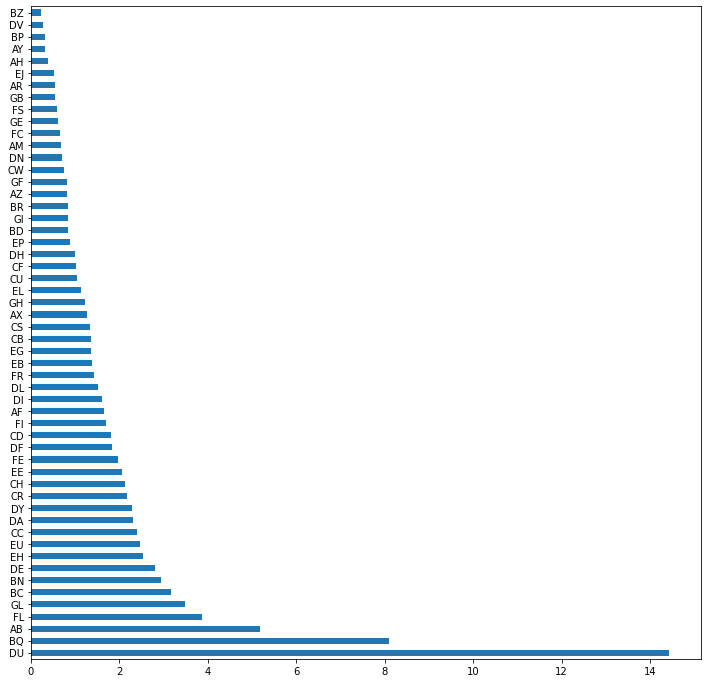

In [33]:
fig1 = plt.figure(figsize=(12,12))
x = pd.Series(catboost_best_est.feature_importances_, index=catboost_best_est.feature_names_).sort_values(ascending=False)
x.nlargest(60).plot(kind = 'barh')
plt.show()